# Prerequisites

- Block ciphers
- PRG, PRF, PRP

# Theory

We are going to see how 1 block of AES works and how to implement it

- https://en.wikipedia.org/wiki/Advanced_Encryption_Standard
- https://www.youtube.com/watch?v=O4xNJsjtN6E&t

## Structure of AES128

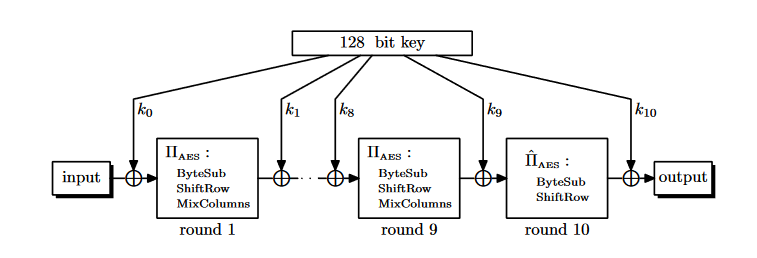

Let $m \in \{0, 1\}^{128}$ be a message encrypted to $c \in \{0, 1\}^{128}$ by some encryption function $E$ that takes a key $k \in \{0, 1\}^{128}$
- $m$ has 16 bytes
- AES works with a 4x4 column major *state*

Let's define some helper functions


In [13]:
def bytes_to_matrix(text):
    """ Converts a 16-byte array into a 4x4 matrix.  """
    return [list(text[i:i+4]) for i in range(0, len(text), 4)]

def matrix_to_bytes(matrix):
    """ Converts a 4x4 matrix into a 16-byte array.  """
    return bytes(sum(matrix, []))

In [14]:
M = bytes_to_matrix(b'Some 16byte text')
print(M)
print(matrix_to_bytes(M))

[[83, 111, 109, 101], [32, 49, 54, 98], [121, 116, 101, 32], [116, 101, 120, 116]]
b'Some 16byte text'


### Algorithm workflow

**1. KeyExpansion**
– round keys are derived from the cipher key using the **AES key schedule**. AES requires a separate 128-bit round key block for each round plus one more.

**2.Initial round key addition:**
- *AddRoundKey* – each byte of the state is combined with a byte of the round key using bitwise xor.

**3.Then we have 9, 11 or 13 rounds:**
- *SubBytes* – a **non-linear substitution step** where each byte is replaced with another according to a lookup table.
- *ShiftRows* – a transposition step where the last three rows of the state are shifted cyclically a certain number of steps.
- *MixColumns* – a **linear mixing operation** which operates on the columns of the state, combining the four bytes in each column.
- *AddRoundKey*

**4. Final round**(making 10, 12 or 14 rounds in total):
- *SubBytes*
- *ShiftRows*
- *AddRoundKey*



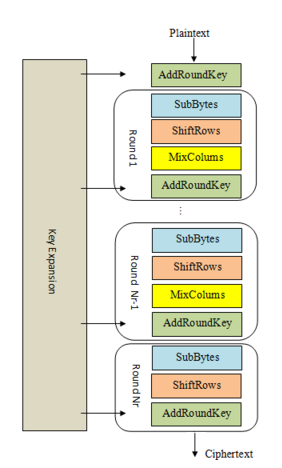

## Round keys

The initial key addition phase, which is next, has a single AddRoundKey step. The AddRoundKey step is straightforward: it XORs the current state with the current round key.
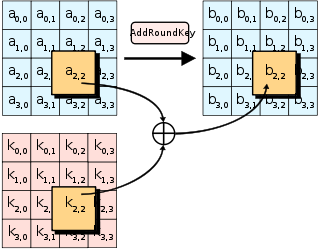

AddRoundKey also occurs as the final step of each round. AddRoundKey is what makes AES a "keyed permutation" rather than just a permutation. It's the only part of AES where the key is mixed into the state, but is crucial for determining the permutation that occurs.


In [15]:
def add_round_key(s, k):
    return [[sss^kkk for sss, kkk in zip(ss,kk)] for ss, kk in zip(s, k)]

## Confusion through Substitution

The first step of each AES round is **SubBytes**. 
Let
- $S:\{0,1\}^8 \longrightarrow \{0,1\}^8$ be a fixed permutation (a one-to-one function).  This 
- permutation  is  applied  to  each  of  the  16  cells,  one  cell  at  a  time
- Specified in AES standard -> Hard coded

*Intuition*: 
- This involves taking each byte of the state matrix and substituting it for a different byte in a preset 16x16 lookup table. 
- The lookup table is called a "Substitution box" or "S-box" for short

**Design**
- No fixed points $S(x) \neq x \ \forall  x \in \{0, 1\}^8$
- No inverse points $S(x) \neq \bar{x}$  where  $\bar{x}$ is the complement of bits (bit flipped $x$)

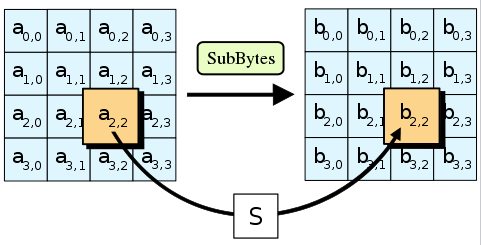

**Motivation**
- "Confusion" = Given just a ciphertext, there should be no way to learn anything about the key. => Complex relationship between ciphertext and key
- The main purpose of the S-box is to transform the input in a way that is resistant to being approximated by linear functions => **high non-linearity**

**How is the S-box computed**

- https://www.samiam.org/galois.html
- $A_i \longrightarrow \boxed{GF(2^8) \text{inverse}} \longrightarrow B_i' \longrightarrow \boxed{\text{Affine mapping}} \longrightarrow B_i$

- Let $A_i \in GF(2^8)$
    - Ex: $A_i = 1100 0010 => A_i(x) = x^7 + x^6 + x$
- Compute its inverse $B_i' = x^5 + x^3 + x^2 + x + 1 = A_i(x)^{-1} => B_i' = 0010 \ 1111$
- $A_i(x) \cdot B_i'(x) = 1 \bmod x^8 + x^4 + x^3 + x + 1$
- Now you want another transformation that destroys this propriety -> Affine mapping = matrix multiplication with a fixed matrix and add a constant C
-  $B_i = B_i' * M + C$

- https://en.wikipedia.org/wiki/Rijndael_S-box



In [16]:
s_box = (
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16,
)

inv_s_box = (
    0x52, 0x09, 0x6A, 0xD5, 0x30, 0x36, 0xA5, 0x38, 0xBF, 0x40, 0xA3, 0x9E, 0x81, 0xF3, 0xD7, 0xFB,
    0x7C, 0xE3, 0x39, 0x82, 0x9B, 0x2F, 0xFF, 0x87, 0x34, 0x8E, 0x43, 0x44, 0xC4, 0xDE, 0xE9, 0xCB,
    0x54, 0x7B, 0x94, 0x32, 0xA6, 0xC2, 0x23, 0x3D, 0xEE, 0x4C, 0x95, 0x0B, 0x42, 0xFA, 0xC3, 0x4E,
    0x08, 0x2E, 0xA1, 0x66, 0x28, 0xD9, 0x24, 0xB2, 0x76, 0x5B, 0xA2, 0x49, 0x6D, 0x8B, 0xD1, 0x25,
    0x72, 0xF8, 0xF6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xD4, 0xA4, 0x5C, 0xCC, 0x5D, 0x65, 0xB6, 0x92,
    0x6C, 0x70, 0x48, 0x50, 0xFD, 0xED, 0xB9, 0xDA, 0x5E, 0x15, 0x46, 0x57, 0xA7, 0x8D, 0x9D, 0x84,
    0x90, 0xD8, 0xAB, 0x00, 0x8C, 0xBC, 0xD3, 0x0A, 0xF7, 0xE4, 0x58, 0x05, 0xB8, 0xB3, 0x45, 0x06,
    0xD0, 0x2C, 0x1E, 0x8F, 0xCA, 0x3F, 0x0F, 0x02, 0xC1, 0xAF, 0xBD, 0x03, 0x01, 0x13, 0x8A, 0x6B,
    0x3A, 0x91, 0x11, 0x41, 0x4F, 0x67, 0xDC, 0xEA, 0x97, 0xF2, 0xCF, 0xCE, 0xF0, 0xB4, 0xE6, 0x73,
    0x96, 0xAC, 0x74, 0x22, 0xE7, 0xAD, 0x35, 0x85, 0xE2, 0xF9, 0x37, 0xE8, 0x1C, 0x75, 0xDF, 0x6E,
    0x47, 0xF1, 0x1A, 0x71, 0x1D, 0x29, 0xC5, 0x89, 0x6F, 0xB7, 0x62, 0x0E, 0xAA, 0x18, 0xBE, 0x1B,
    0xFC, 0x56, 0x3E, 0x4B, 0xC6, 0xD2, 0x79, 0x20, 0x9A, 0xDB, 0xC0, 0xFE, 0x78, 0xCD, 0x5A, 0xF4,
    0x1F, 0xDD, 0xA8, 0x33, 0x88, 0x07, 0xC7, 0x31, 0xB1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xEC, 0x5F,
    0x60, 0x51, 0x7F, 0xA9, 0x19, 0xB5, 0x4A, 0x0D, 0x2D, 0xE5, 0x7A, 0x9F, 0x93, 0xC9, 0x9C, 0xEF,
    0xA0, 0xE0, 0x3B, 0x4D, 0xAE, 0x2A, 0xF5, 0xB0, 0xC8, 0xEB, 0xBB, 0x3C, 0x83, 0x53, 0x99, 0x61,
    0x17, 0x2B, 0x04, 0x7E, 0xBA, 0x77, 0xD6, 0x26, 0xE1, 0x69, 0x14, 0x63, 0x55, 0x21, 0x0C, 0x7D,
)

def lookup_function(x):
    return 0x05 * pow(x,0xFE) + 0x09*pow(x, 0xFD) + 0xF9 * pow(x, 0xFB) + 0x25 * pow(x, 0xF7) + 0xF4 * pow(x, 0xEF) + 0x01 * pow(x, 0xDF) + 0xB5 * pow(x, 0xBF) + 0x8F * pow(x, 0x7F) + 63


def sub_bytes(s, sbox):
    l = []
    for i in s:
        for j in i:
            l.append(sbox[j])
    return [[sbox[s[i][j]] for j in range(len(s[i]))] for i in range(len(s))]

## Diffusion through permutation

**ShiftRows** is just a cyclic shift 
- 1st row stays in place
- 2nd row rotates 1B to the left
- 3rd row rotates 2B to the left
- 4th row rotates 3B to the left
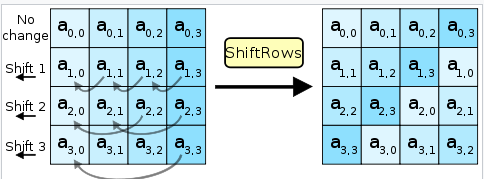


**MixColumns**
- In this step the $4×4$ array is treated as a matrix and this matrix is multiplied by  a  fixed  matrix  where  arithmetic  is  interpreted  in  the  finite  field  $GF(2^8)$
- Elements in $GF(2^8)$ are polynomials in $GF(2)$ of degree < $8$ with multiplication done $\bmod x^8+x^4+x^3+x+1$ .
- If 1 bit at the input message this operation takes care that all the bits in the output cipher are affected
- https://en.wikipedia.org/wiki/Rijndael_MixColumns

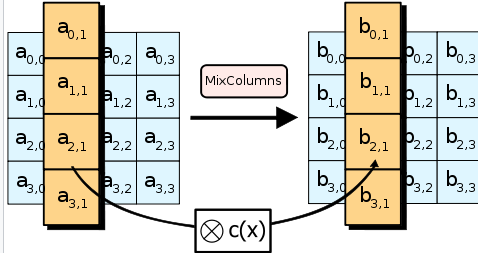


**Motivation**
- Substitution on its own creates non-linearity, however it doesn't distribute it over the entire state.
- Without diffusion, the same byte in the same position would get the same transformations applied to it each round. This would allow cryptanalysts to attack each byte position in the state matrix separately.

We need to alternate substitutions by scrambling the state (in an invertible way) so that substitutions applied on one byte influence all other bytes in the state. Each input into the next S-box then becomes a function of multiple bytes, meaning that with every round the algebraic complexity of the system increases enormously.

https://en.wikipedia.org/wiki/Avalanche_effect = if an input is changed slightly (for example, flipping a single bit), the output changes significantly (e.g., half the output bits flip)

In [17]:
def shift_rows(s):
    s[0][1], s[1][1], s[2][1], s[3][1] = s[1][1], s[2][1], s[3][1], s[0][1]
    s[0][2], s[1][2], s[2][2], s[3][2] = s[2][2], s[3][2], s[0][2], s[1][2]
    s[0][3], s[1][3], s[2][3], s[3][3] = s[3][3], s[0][3], s[1][3], s[2][3]
    return s

def inv_shift_rows(s):
    s[1][1], s[2][1], s[3][1], s[0][1] = s[0][1], s[1][1], s[2][1], s[3][1]
    s[2][2], s[3][2], s[0][2], s[1][2] = s[0][2], s[1][2], s[2][2], s[3][2] 
    s[3][3], s[0][3], s[1][3], s[2][3] = s[0][3], s[1][3], s[2][3], s[3][3]
    return s


# learned from http://cs.ucsb.edu/~koc/cs178/projects/JT/aes.c
xtime = lambda a: (((a << 1) ^ 0x1B) & 0xFF) if (a & 0x80) else (a << 1)


def mix_single_column(a):
    # see Sec 4.1.2 in The Design of Rijndael
    t = a[0] ^ a[1] ^ a[2] ^ a[3]
    u = a[0]
    a[0] ^= t ^ xtime(a[0] ^ a[1])
    a[1] ^= t ^ xtime(a[1] ^ a[2])
    a[2] ^= t ^ xtime(a[2] ^ a[3])
    a[3] ^= t ^ xtime(a[3] ^ u)
    return a


def mix_columns(s):
    for i in range(4):
        s[i] = mix_single_column(s[i])
    return s


def inv_mix_columns(s):
    # see Sec 4.1.3 in The Design of Rijndael
    for i in range(4):
        u = xtime(xtime(s[i][0] ^ s[i][2]))
        v = xtime(xtime(s[i][1] ^ s[i][3]))
        s[i][0] ^= u
        s[i][1] ^= v
        s[i][2] ^= u
        s[i][3] ^= v
    s = mix_columns(s)
    return s

## Key expansion

- https://en.wikipedia.org/wiki/AES_key_schedule

We need to generate the round keys $k_0,...,k_{10}$ where each round key is $128$ bits.  

- To do so, the 128-bit AES key is partitioned into four 32-bit words $w_{0,0},w_{0,1},w_{0,2},w_{0,3}$ and these form the first round key $k_0$.  

- The remaining ten round keys are generated sequentially:  
    - for $i= 1,...,10$ the 128-bit round key $k_i= (w_{i,0},w_{i,1},w_{i,2},w_{i,3})$ is generated from the preceding round key $k_{i−1}=(w_{i−1,0},w_{i−1,1},w_{i−1,2},w_{i−1,3}):
    
    - $w_{i,0}←w_{i−1,0}⊕g_{i}(w_{i−1,3})$
    - $w_{i,1}←w_{i−1},1⊕w_{i,0}$
    - $w_{i,2}←w_{i−1,2}⊕w_{i,1}$
    - $w_{i,3}←w_{i−1,3}⊕w_{i,2}$
    
Where the function $g_i:{0,1}^{32}→ {0,1}^{32}$ is  a  fixed  function  specified  in  the  AES  standard.   
    
    
It operates on its four byte input in three steps:  
- perform a one-byte left circular rotation on the $4$-byte input
- apply SubBytes to each of the four bytes obtained
- XOR the left most byte with a fixed round constant $c_i$.  
    - Where the round constants $c_1,...,c_{10}$ are specified in the AES standard: round constant number $i$ is the element $x^{i−1}$ of the field $GF(2^8)$ treated as an $8$-bit string.
    
    
The AES key expansion method is intentionally designed to be invertible:  given the last roundkey, one can work backwards to recover the full AES secret key $k$.  The reason for this is to ensure that every AES-128 round key, on its own, has the same amount of entropy as the AES-128 secret key $k$.  If AES-128 key expansion were not invertible then the last round key would not be uniform in $\{0,1\}^{128}$

In [20]:
def expand_key(master_key):
    """
    Expands and returns a list of key matrices for the given master_key.
    """

    # Round constants https://en.wikipedia.org/wiki/AES_key_schedule#Round_constants
    r_con = (
        0x00, 0x01, 0x02, 0x04, 0x08, 0x10, 0x20, 0x40,
        0x80, 0x1B, 0x36, 0x6C, 0xD8, 0xAB, 0x4D, 0x9A,
        0x2F, 0x5E, 0xBC, 0x63, 0xC6, 0x97, 0x35, 0x6A,
        0xD4, 0xB3, 0x7D, 0xFA, 0xEF, 0xC5, 0x91, 0x39,
    )

    # Initialize round keys with raw key material.
    key_columns = bytes_to_matrix(master_key)
    iteration_size = len(master_key) // 4

    # Each iteration has exactly as many columns as the key material.
    columns_per_iteration = len(key_columns)
    i = 1
    while len(key_columns) < (N_ROUNDS + 1) * 4:
        # Copy previous word.
        word = list(key_columns[-1])

        # Perform schedule_core once every "row".
        if len(key_columns) % iteration_size == 0:
            # Circular shift.
            word.append(word.pop(0))
            # Map to S-BOX.
            word = [s_box[b] for b in word]
            # XOR with first byte of R-CON, since the others bytes of R-CON are 0.
            word[0] ^= r_con[i]
            i += 1
        elif len(master_key) == 32 and len(key_columns) % iteration_size == 4:
            # Run word through S-box in the fourth iteration when using a
            # 256-bit key.
            word = [s_box[b] for b in word]

        # XOR with equivalent word from previous iteration.
        word = bytes(i^j for i, j in zip(word, key_columns[-iteration_size]))
        key_columns.append(word)

    # Group key words in 4x4 byte matrices.
    return [key_columns[4*i : 4*(i+1)] for i in range(len(key_columns) // 4)]

In [21]:
key = b'\xc3,\\\xa6\xb5\x80^\x0c\xdb\x8d\xa5z*\xb6\xfe\\'
expand_key(key)

[[[195, 44, 92, 166],
  [181, 128, 94, 12],
  [219, 141, 165, 122],
  [42, 182, 254, 92]],
 [b'\x8c\x97\x16C', b'9\x17HO', b'\xe2\x9a\xed5', b'\xc8,\x13i'],
 [b'\xff\xea\xef\xab', b'\xc6\xfd\xa7\xe4', b'$gJ\xd1', b'\xecKY\xb8'],
 [b'H!\x83e', b'\x8e\xdc$\x81', b'\xaa\xbbnP', b'F\xf07\xe8'],
 [b'\xcc\xbb\x18?', b'Bg<\xbe', b'\xe8\xdcR\xee', b'\xae,e\x06'],
 [b'\xad\xf6w\xdb', b'\xef\x91Ke', b'\x07M\x19\x8b', b'\xa9a|\x8d'],
 [b'b\xe6*\x08', b'\x8dwam', b'\x8a:x\xe6', b'#[\x04k'],
 [b'\x1b\x14U.', b'\x96c4C', b'\x1cYL\xa5', b'?\x02H\xce'],
 [b'\xecF\xde[', b'z%\xea\x18', b'f|\xa6\xbd', b'Y~\xees'],
 [b'\x04nQ\x90', b'~K\xbb\x88', b'\x187\x1d5', b'AI\xf3F'],
 [b'\tc\x0b\x13', b'w(\xb0\x9b', b'o\x1f\xad\xae', b'.V^\xe8']]

## The AES128 block

In [79]:
class AESBlock:
    def __init__(self, key, n_rounds = 10):
        self.key = key
        self.n_rounds = n_rounds

    def encrypt(self, plaintext, key = None):
        if key is None:
            key = self.key
            
        #Expand key
        round_keys = expand_key(key) 
        # Convert ciphertext to state matrix
        state = bytes_to_matrix(plaintext)
        # Initial add round key step
        state = add_round_key(state, round_keys[0])
        
        #9 AES rounds
        for i in range(1, self.n_rounds):
            state = sub_bytes(state, sbox = s_box)
            state = shift_rows(state)
            state = mix_columns(state)
            state = add_round_key(state, [list(x) for x in round_keys[i]])

        # Run final round (skips the InvMixColumns step)
        state = sub_bytes(state, sbox = s_box)
        state = shift_rows(state)
        state = add_round_key(state, round_keys[self.n_rounds])
        # Convert state matrix to plaintext
        ciphertext = matrix_to_bytes(state)
        return ciphertext
        
    def decrypt(self, ciphertext, key = None):
        if key is None:
            key = self.key
            
        round_keys = expand_key(key) # Remember to start from the last round key and work backwards through them when decrypting
        # Convert ciphertext to state matrix
        state = bytes_to_matrix(ciphertext)
        # Initial add round key step
        state = add_round_key(state, round_keys[self.n_rounds])
        for i in range(self.n_rounds - 1, 0, -1):
            state = inv_shift_rows(state)
            state = sub_bytes(state, sbox = inv_s_box)
            state = add_round_key(state, [list(x) for x in round_keys[i]])
            state = inv_mix_columns(state)

        # Run final round (skips the InvMixColumns step)
        state = inv_shift_rows(state)
        state = sub_bytes(state, sbox = inv_s_box)
        state = add_round_key(state, round_keys[0])
        # Convert state matrix to plaintext
        plaintext = matrix_to_bytes(state)
        return plaintext

In [80]:
key = b'some 16 byte key'
m = b'some 16 byte msg'
len(m)

16

In [81]:
cipher = AESBlock(key)

In [82]:
c = cipher.encrypt(m)
c

b'\xceB6\xc5J\xc0\xbe\x17w\x04\xdezq\x97\xb5\xca'

In [83]:
m_decr = cipher.decrypt(c)
m_decr

b'some 16 byte msg'

In [84]:
from Crypto.Cipher import AES

In [85]:
cipher = AES.new(key = key, mode=AES.MODE_ECB)
c = cipher.encrypt(m)
print(c)
m_decr = cipher.decrypt(c)
print(m_decr)

b'\xceB6\xc5J\xc0\xbe\x17w\x04\xdezq\x97\xb5\xca'
b'some 16 byte msg'


# Resources

- https://www.youtube.com/watch?v=x1v2tX4_dkQ&t - Christof Paar on Galois Fields
- http://toc.cryptobook.us/